Link dataset 1: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


Link dataset 2:https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet

# Import

In [9]:
import zipfile
import os
import json
import pickle
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from tqdm import tqdm
from PIL import Image
import cv2

2024-06-16 20:16:07.109463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Funzioni Varie

In [2]:
def stampa_previsioni(images,true_labels,pred_labels,num_images = 20):
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i], cmap='gray')  # Usa 'gray' se le immagini sono in scala di grigi
        plt.title("Pred: "+pred_labels[i]+f"\nActual: {true_labels[i]}")
        plt.axis('off')  # Nasconde gli assi

    plt.tight_layout()
    plt.show()

# Caricamento Dataset da Kaggle

In [6]:
%pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "kaggle.json"

In [ ]:
%kaggle datasets download -d grassknoted/asl-alphabet

UsageError: %%python is a cell magic, but the cell body is empty.


In [ ]:


# Define the path to your zip file
file_path = "is-a-block-structure-stable-or-unstable.zip" # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall("./dataset")  # Replace 'destination_folder' with your desired folder

# Caricamento dati

In [17]:
def load_data(data_dir,dim,grayscale=True):
    images = []
    labels = []
    color = cv2.IMREAD_COLOR
    if(grayscale):
        color = cv2.IMREAD_GRAYSCALE
    for root, dirs, files in os.walk(data_dir):
        for label_dir in dirs:
            label = os.path.basename(label_dir)
            label_path = os.path.join(root, label_dir)
            print(f"Caricamento della cartella {label}...")
            for image_file in os.listdir(label_path):
                if image_file.endswith('.jpg') or image_file.endswith('.png'):
                    image_path = os.path.join(label_path, image_file)
                    image = cv2.imread(image_path,color )
                    if image is not None:
                        image = cv2.resize(image, (dim, dim))
                       
                        images.append(image)
                        labels.append(label)
            print(f"Caricamento della cartella {label} completato.")

    return np.array(images), np.array(labels)

In [18]:
train_dir = 'dataset/asl_alphabet_train'
test_dir = 'dataset/asl_alphabet_test'
train_dir_2 = "dataset2/Train_Alphabet"
test_dir_2 = "dataset2/Test_Alphabet"

In [19]:
train_images, train_labels = load_data(train_dir,64,grayscale=True)

Caricamento della cartella asl_alphabet_train...
Caricamento della cartella asl_alphabet_train completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della

## combinazione 2 dataset

In [7]:
train_images_2 , train_labels_2 = load_data(train_dir_2)

TypeError: load_data() missing 1 required positional argument: 'dim'

In [ ]:
train_images=np.vstack((train_images, train_images_2))

In [ ]:
train_labels= np.concatenate((train_labels,train_labels_2))

In [ ]:
test_images, test_labels = load_data(test_dir)

Caricamento della cartella asl_alphabet_test...
Caricamento della cartella asl_alphabet_test completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della c

In [ ]:
train_images.shape

(111300, 64, 64)

## split dati

In [20]:
from sklearn.model_selection import train_test_split

# Dividi il set di addestramento in train e validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42,stratify=train_labels)

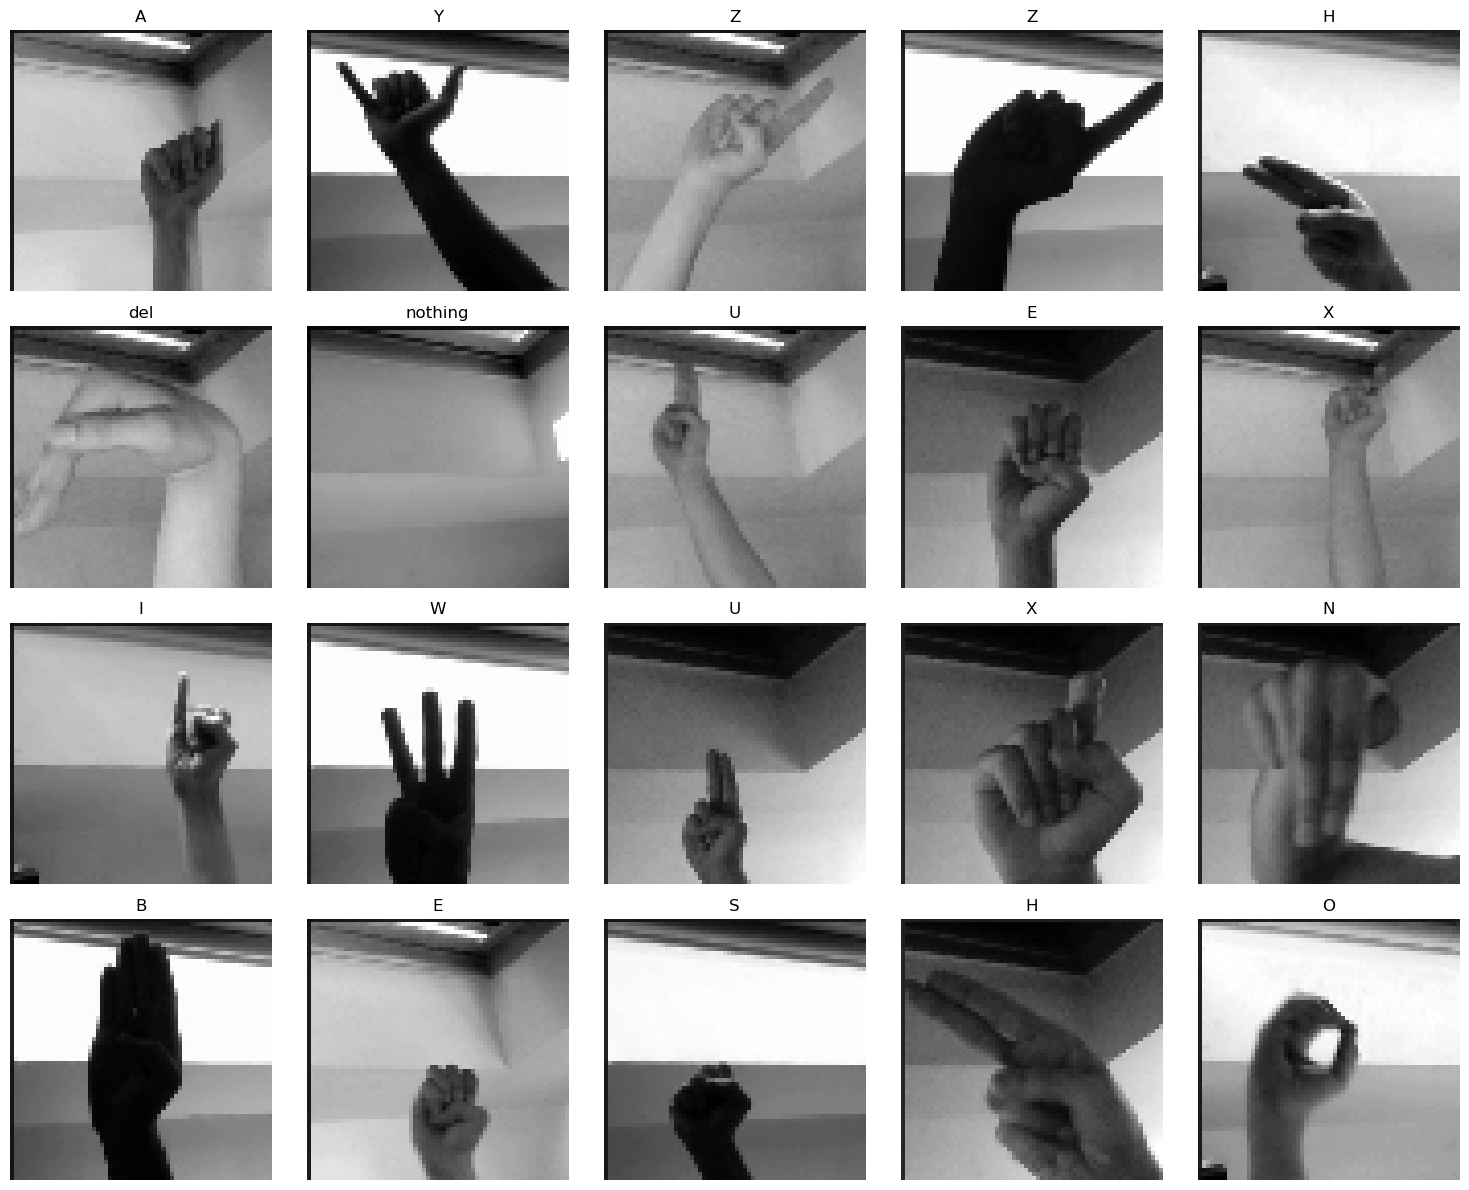

In [48]:
import matplotlib.pyplot as plt

# Numero di immagini da visualizzare
num_images = 20

# Calcola il numero di righe e colonne per il layout del subplot
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(15, 3 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i], cmap='gray')  # Usa 'gray' se le immagini sono in scala di grigi
    plt.title(train_labels[i])
    plt.axis('off')  # Nasconde gli assi

plt.tight_layout()
plt.show()


In [49]:
train_images.shape

(69600, 64, 64)

In [50]:
val_images.shape

(17400, 64, 64)

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [22]:
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)


In [53]:
df = pd.DataFrame(val_labels,columns=["label"])

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

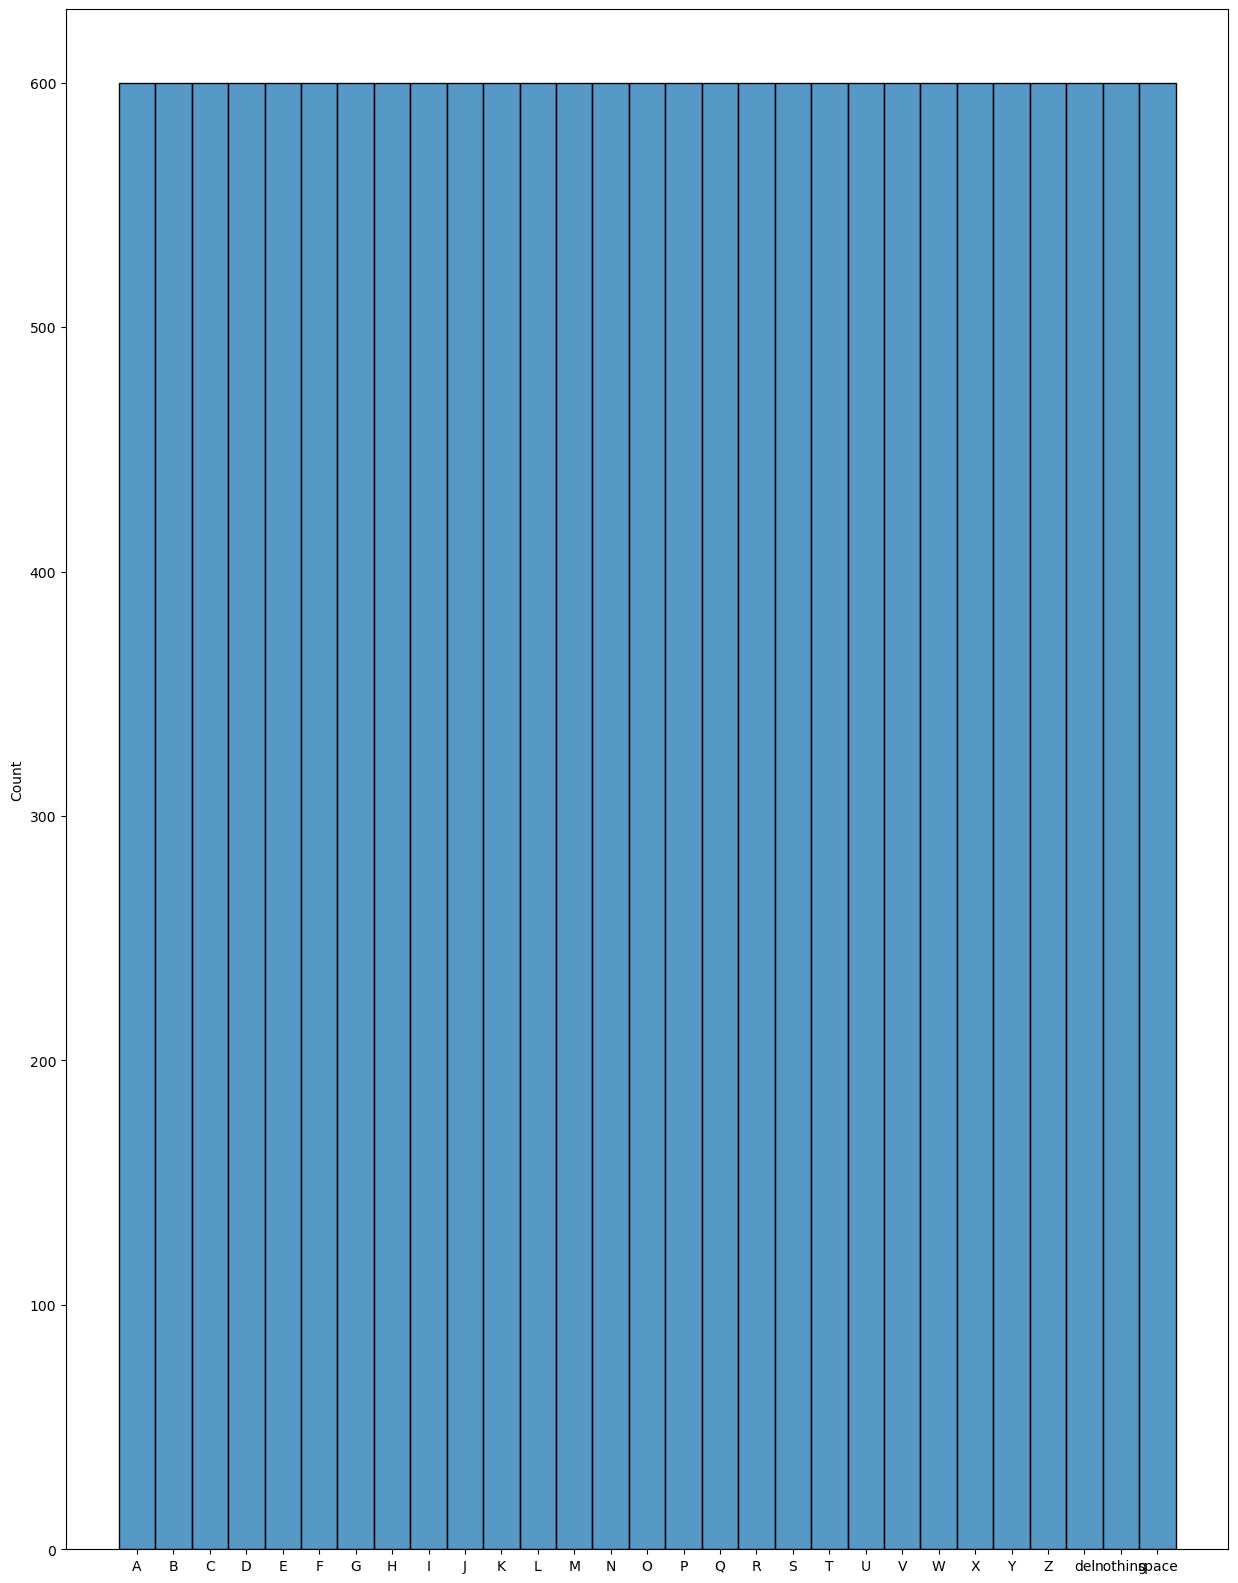

In [54]:
plt.figure(figsize=(15,20))
sns.histplot(data=sorted(df.label),discrete=True)

In [8]:
labels = sorted(set(val_labels)) 

In [56]:
with open("labels2.json", 'w') as file_json:
    json.dump(labels, file_json)

# Numpy

In [23]:
train_images_norm = np.array(train_images)/255
val_images_norm = np.array(val_images)/255
#test_images_norm = np.array(test_images)/255

In [10]:
train_images_vectorized = train_images_norm.reshape(len(train_images_norm), -1)
val_images_vectorized = val_images_norm.reshape(len(val_images_norm), -1)
#test_images_vectorized = test_images_norm.reshape(len(test_images_norm), -1)

# Provo a visualizzare i dati 

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

## Pca

In [22]:
pca = PCA(2)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [23]:
train_pca.shape

(69600, 2)

In [24]:
train_pca_stable = train_pca[train_labels==1,:]

In [25]:
train_pca_unstable = train_pca[train_labels==0,:]

In [26]:
df = pd.DataFrame(train_pca,columns=["x","y"])

In [27]:
labels = pd.DataFrame(train_labels,columns=["labels"])

In [28]:
df = pd.concat([df,labels],axis=1)

In [29]:
df.shape

(69600, 3)

In [30]:
df.columns

Index(['x', 'y', 'labels'], dtype='object')

In [31]:
df.head()

,x,y,labels
0,-0.003733,-0.036216,A
1,0.033081,0.021496,Y
2,-0.004233,-0.024579,Z
3,0.021291,0.033344,Z
4,0.018388,0.020552,H


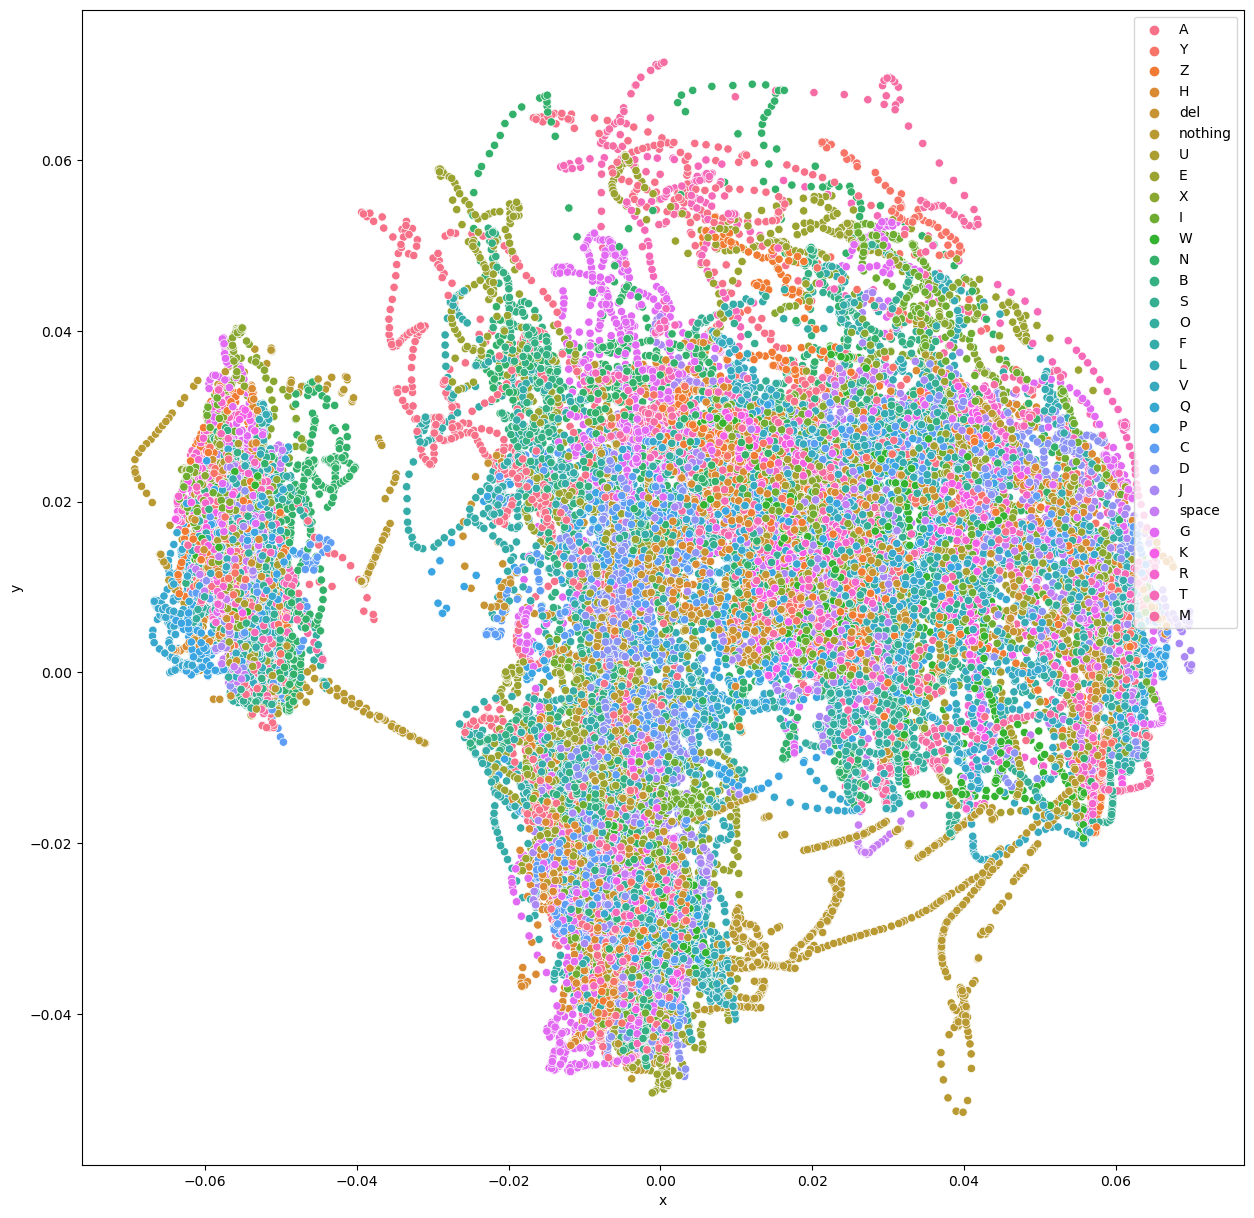

In [33]:
plt.figure(figsize=(15, 15))
sns.scatterplot(data=df,x="x",y="y", hue='labels')
plt.legend()
plt.show()

# Tentativo Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
clf = DecisionTreeClassifier(random_state=42)

# Addestra il modello
clf.fit(train_images_vectorized, train_labels)

# Predice i valori di test
y_pred = clf.predict(train_images_vectorized)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(train_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [29]:
y_val_pred = clf.predict(val_images_vectorized)

In [31]:
accuracy = accuracy_score(val_labels, y_val_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


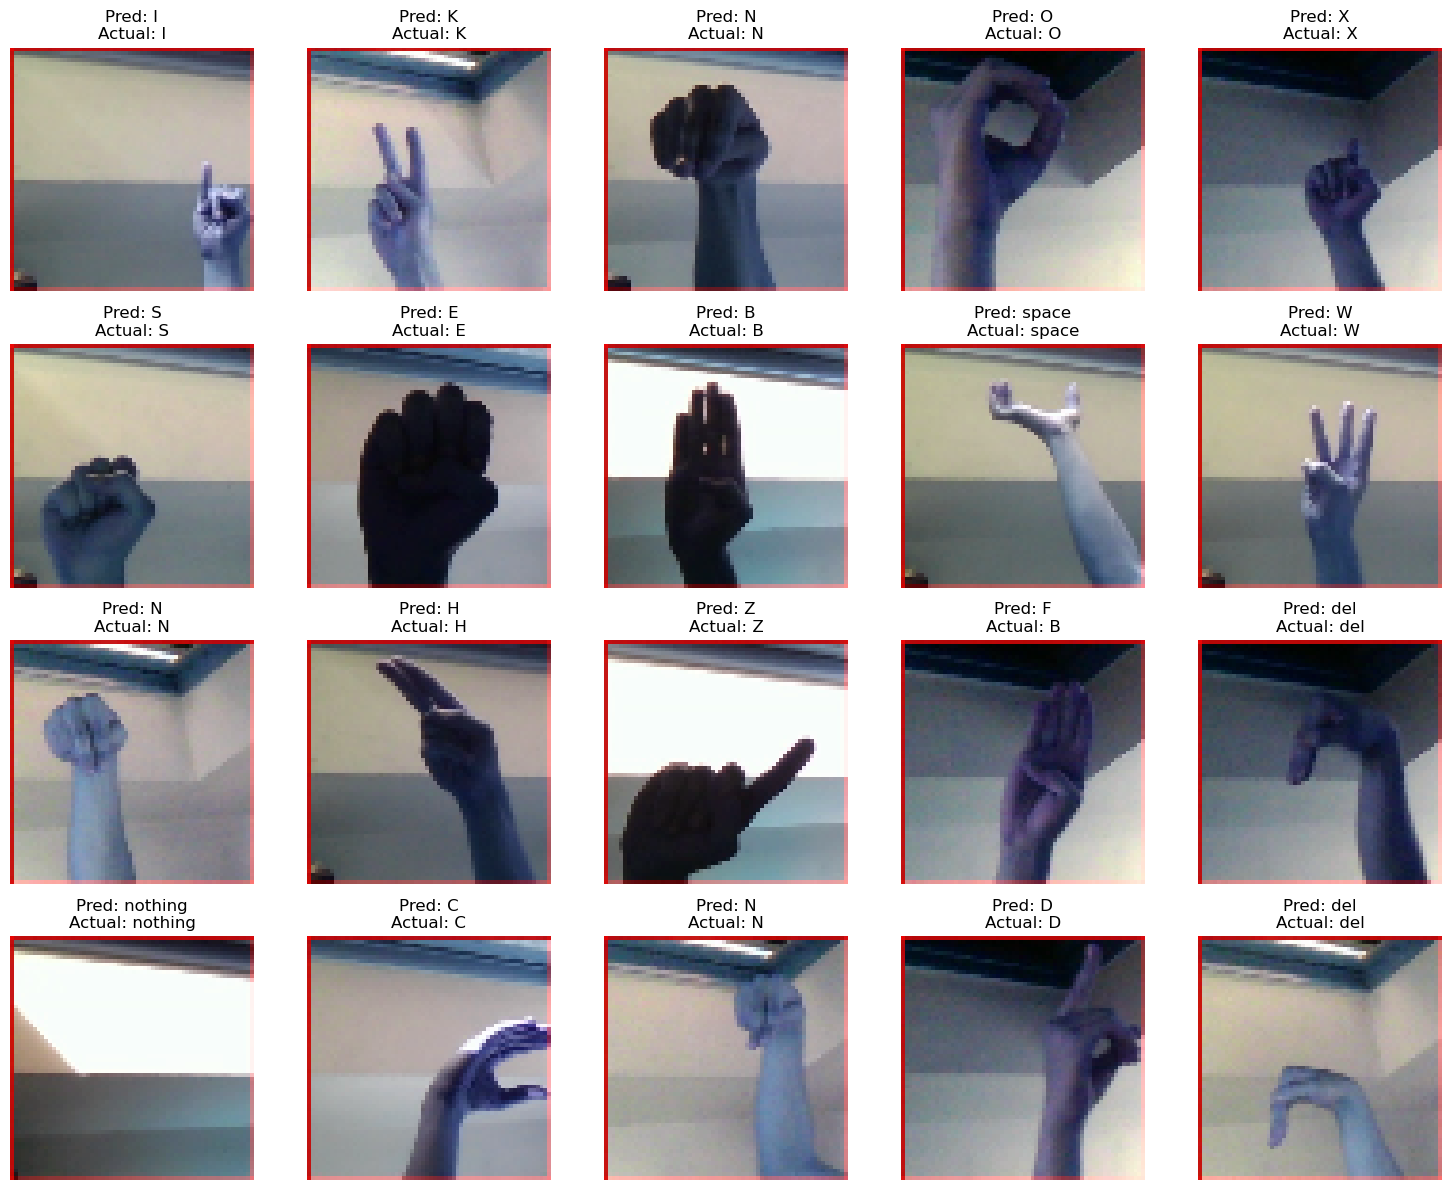

In [32]:
stampa_previsioni(val_images,val_labels,y_val_pred)

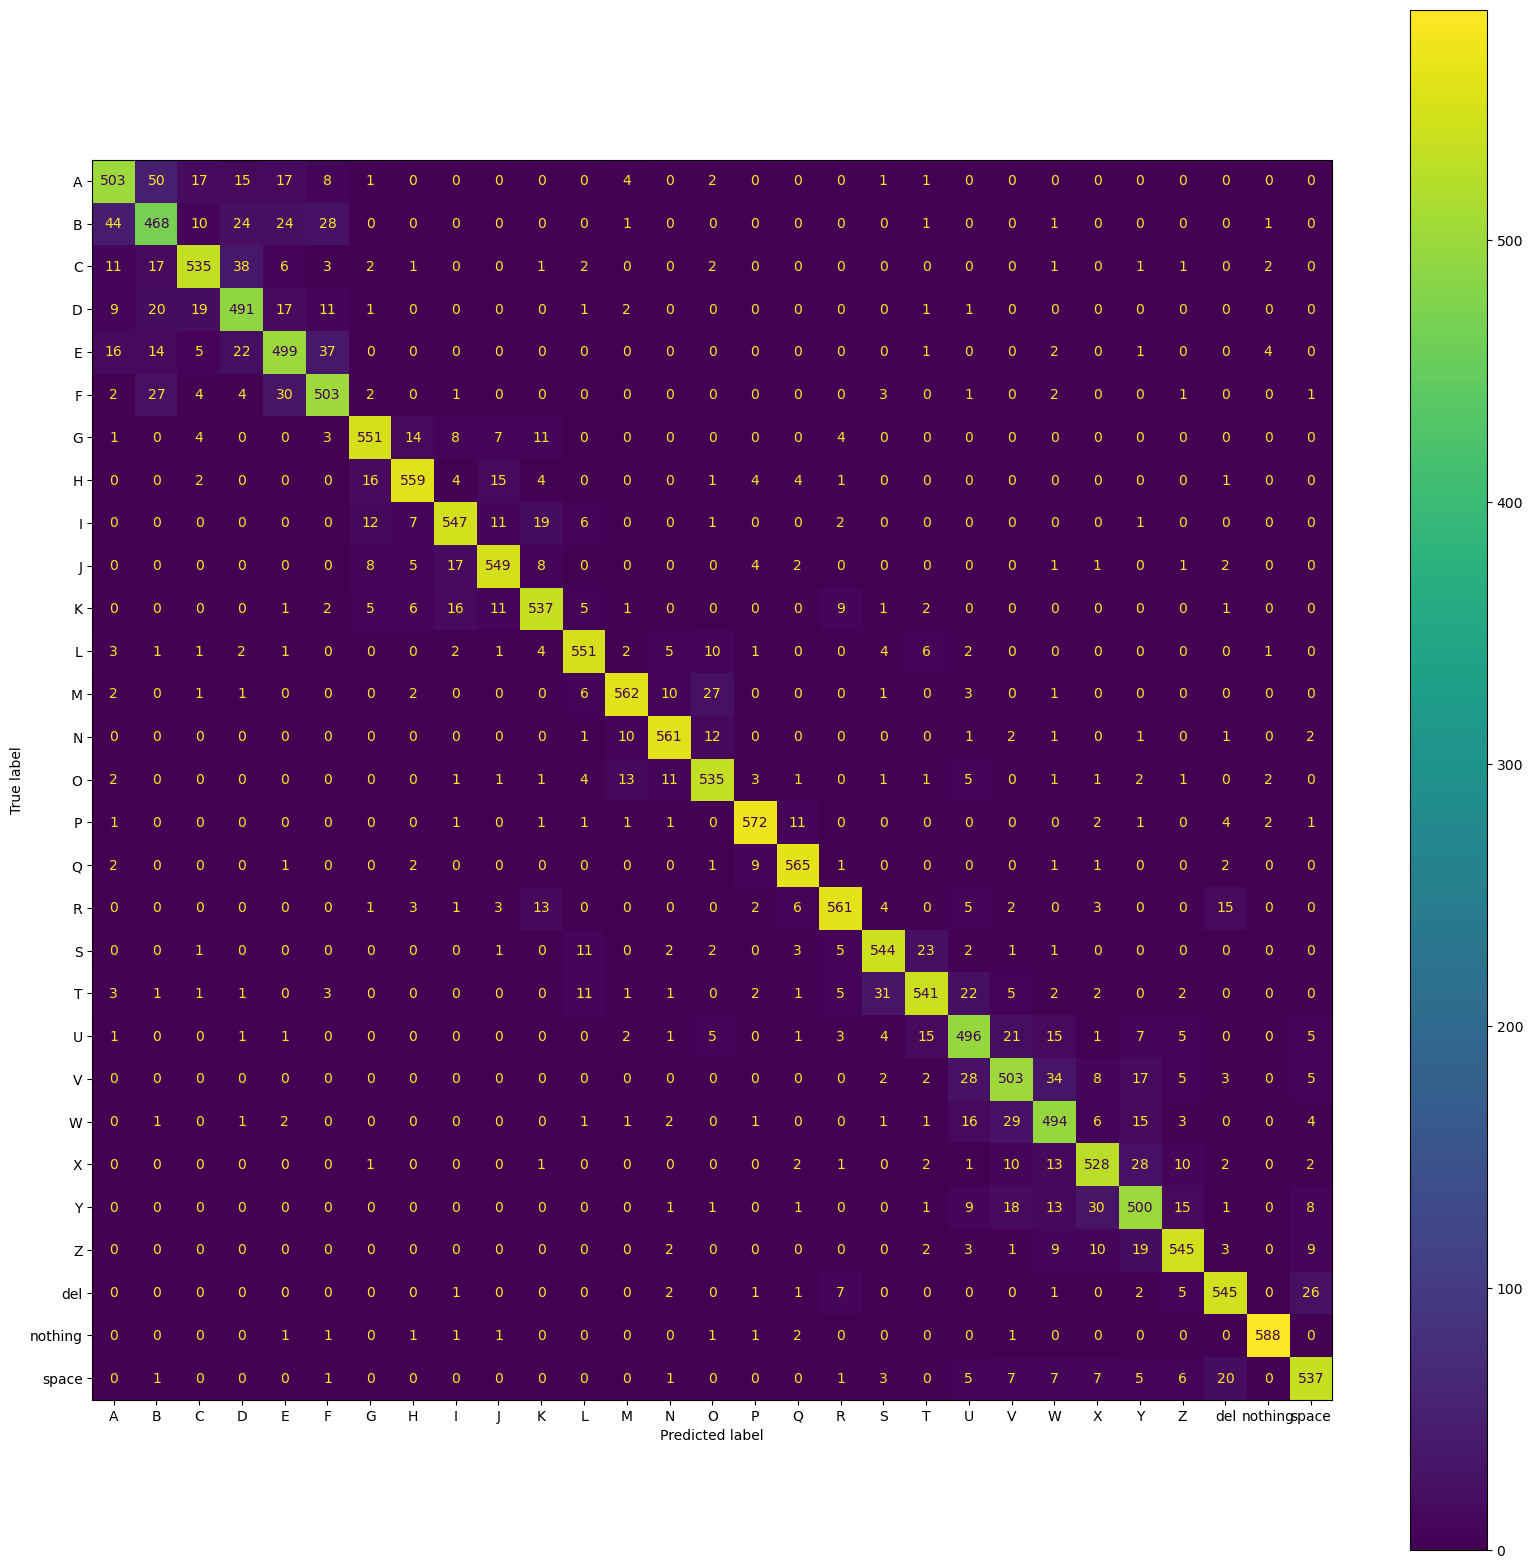

In [35]:
fig,ax=plt.subplots(figsize=(20, 20))
conf_matrix = confusion_matrix(y_val_pred, val_labels)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=sorted(labels)).plot(ax=ax)
plt.show()

## Salvatggio

In [38]:
with open('./Modelli/tree_vect_images.pkl', 'wb') as file:
    pickle.dump(clf, file)

# Tentativo Rete neurale

In [24]:
model = models.Sequential([
    layers.Flatten(input_shape=(64,64)), 
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [27]:
nn_callback = tf.keras.callbacks.TensorBoard('./logs/NN', update_freq=1)

In [28]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback,nn_callback])

Epoch 1/100
2175/2175 [==============================] - 20s 9ms/step - loss: 2.2691 - accuracy: 0.2963 - val_loss: 1.4753 - val_accuracy: 0.5084
Epoch 2/100
2175/2175 [==============================] - 18s 8ms/step - loss: 1.2925 - accuracy: 0.5548 - val_loss: 1.0673 - val_accuracy: 0.6282
Epoch 3/100
2175/2175 [==============================] - 17s 8ms/step - loss: 0.9939 - accuracy: 0.6523 - val_loss: 0.9395 - val_accuracy: 0.6734
Epoch 4/100
2175/2175 [==============================] - 16s 7ms/step - loss: 0.8250 - accuracy: 0.7059 - val_loss: 0.7711 - val_accuracy: 0.7283
Epoch 5/100
2175/2175 [==============================] - 16s 7ms/step - loss: 0.7104 - accuracy: 0.7455 - val_loss: 0.8153 - val_accuracy: 0.7025
Epoch 6/100
2175/2175 [==============================] - 16s 7ms/step - loss: 0.6439 - accuracy: 0.7665 - val_loss: 0.6054 - val_accuracy: 0.7791
Epoch 7/100
2175/2175 [==============================] - 16s 8ms/step - loss: 0.5778 - accuracy: 0.7917 - val_loss: 0.5126 -

In [73]:
y_val_pred = model.predict(val_images_norm)
y_val_pred = np.argmax(y_val_pred,axis=1)

544/544 [==============================] - 1s 2ms/step


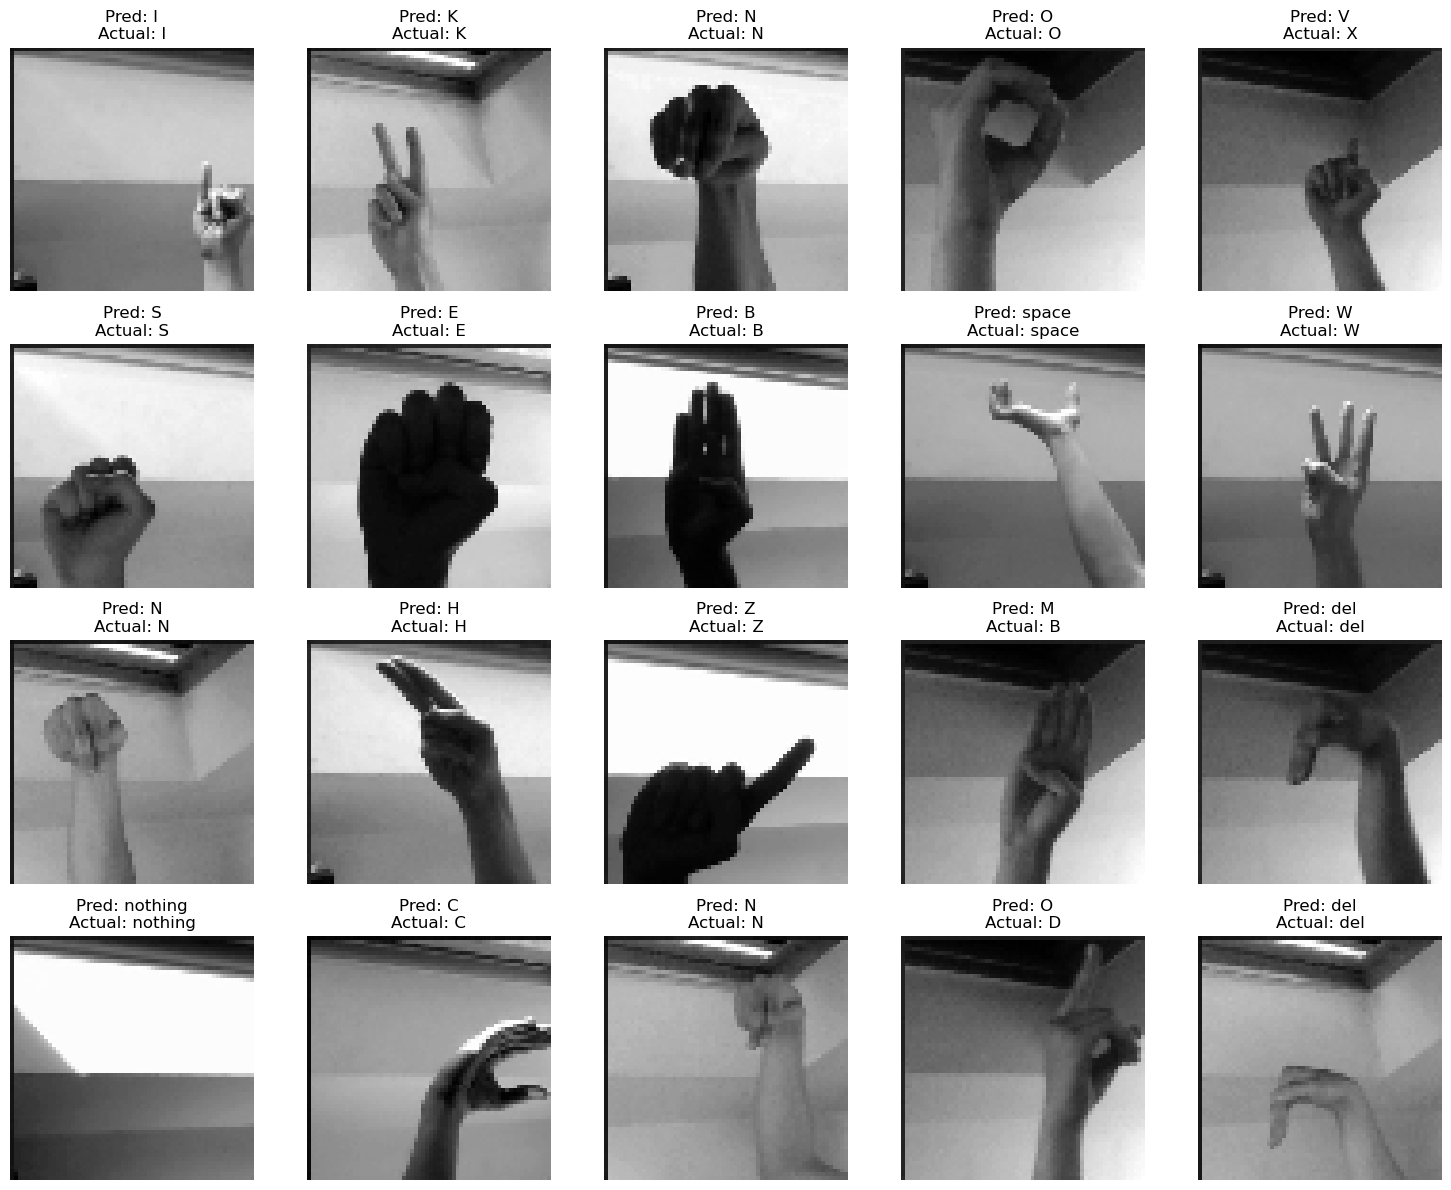

In [75]:
stampa_previsioni(val_images,val_labels,label_encoder.inverse_transform(y_val_pred))

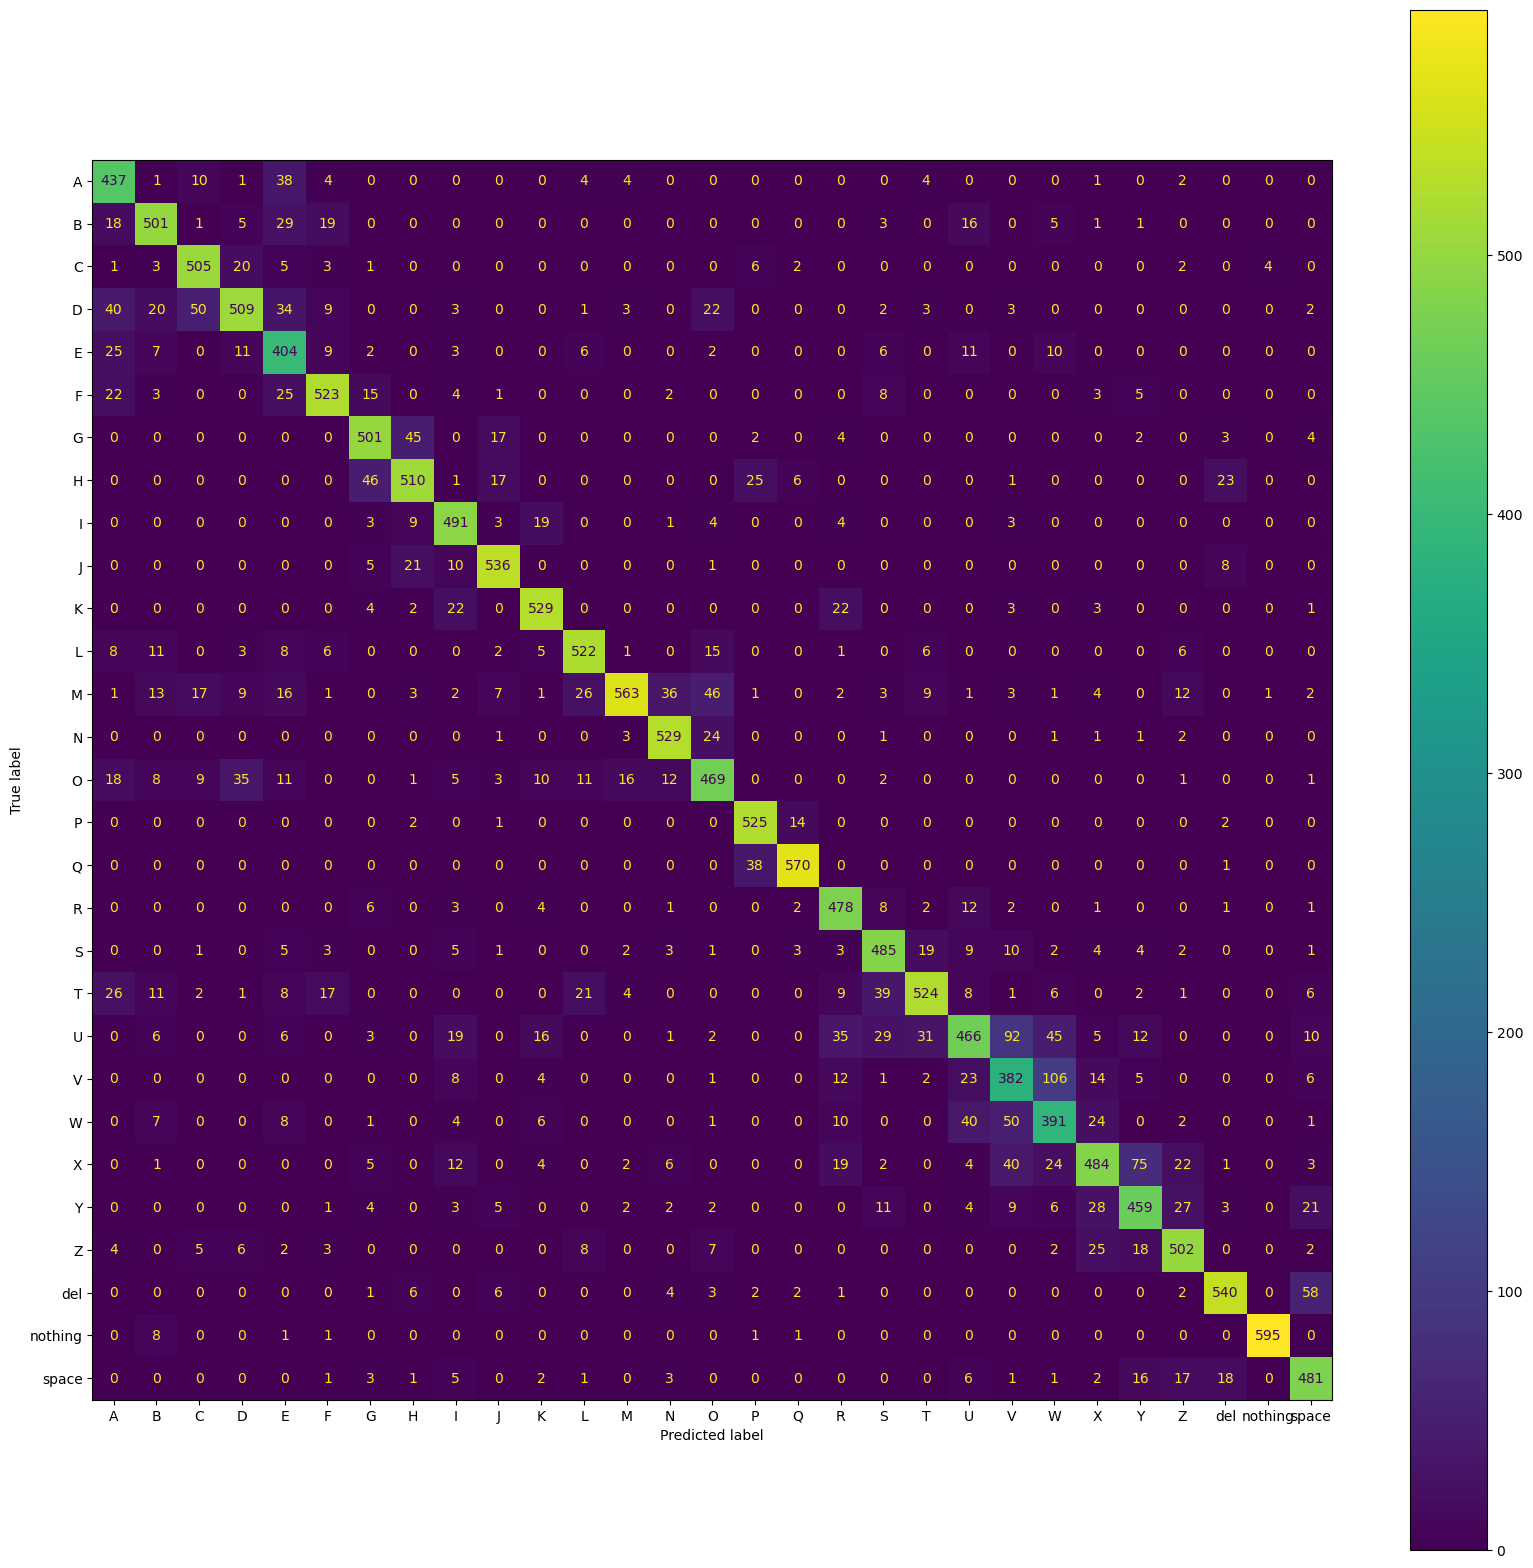

In [76]:
fig,ax=plt.subplots(figsize=(20, 20))
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_val_pred), val_labels)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=sorted(labels)).plot(ax=ax)
plt.show()

## Salvataggio

In [77]:
model.save("./Modelli/modello1")

INFO:tensorflow:Assets written to: ./Modelli/modello1/assets


In [39]:
model = tf.keras.models.load_model("./Modelli/modello1")

2024-06-15 09:27:33.342341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Tentativo PCA+Rete Neurale

In [81]:
pca = PCA(0.9)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [82]:
val_pca = pca.transform(val_images_vectorized)

In [79]:
train_pca.shape

(69600, 40)

In [83]:
model_2 = models.Sequential([
    layers.Dense(40, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [84]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [86]:
model_2.fit(train_pca, train_labels_encoded, epochs=100,validation_data=[val_pca,val_labels_encoded],callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.6025 - accuracy: 0.5084 - val_loss: 0.9605 - val_accuracy: 0.6987
Epoch 2/100
2175/2175 [==============================] - 2s 1ms/step - loss: 0.7544 - accuracy: 0.7606 - val_loss: 0.5984 - val_accuracy: 0.8060
Epoch 3/100
2175/2175 [==============================] - 2s 983us/step - loss: 0.4932 - accuracy: 0.8418 - val_loss: 0.4147 - val_accuracy: 0.8656
Epoch 4/100
2175/2175 [==============================] - 2s 996us/step - loss: 0.3587 - accuracy: 0.8851 - val_loss: 0.3438 - val_accuracy: 0.8857
Epoch 5/100
2175/2175 [==============================] - 2s 1ms/step - loss: 0.2752 - accuracy: 0.9114 - val_loss: 0.2628 - val_accuracy: 0.9111
Epoch 6/100
2175/2175 [==============================] - 2s 999us/step - loss: 0.2199 - accuracy: 0.9285 - val_loss: 0.2093 - val_accuracy: 0.9298
Epoch 7/100
2175/2175 [==============================] - 2s 966us/step - loss: 0.1806 - accuracy: 0.9419 - val_loss: 0.1774 

In [91]:
y_val_pred = model_2.predict(val_pca)
y_val_pred = np.argmax(y_val_pred,axis=1)

544/544 [==============================] - 0s 477us/step


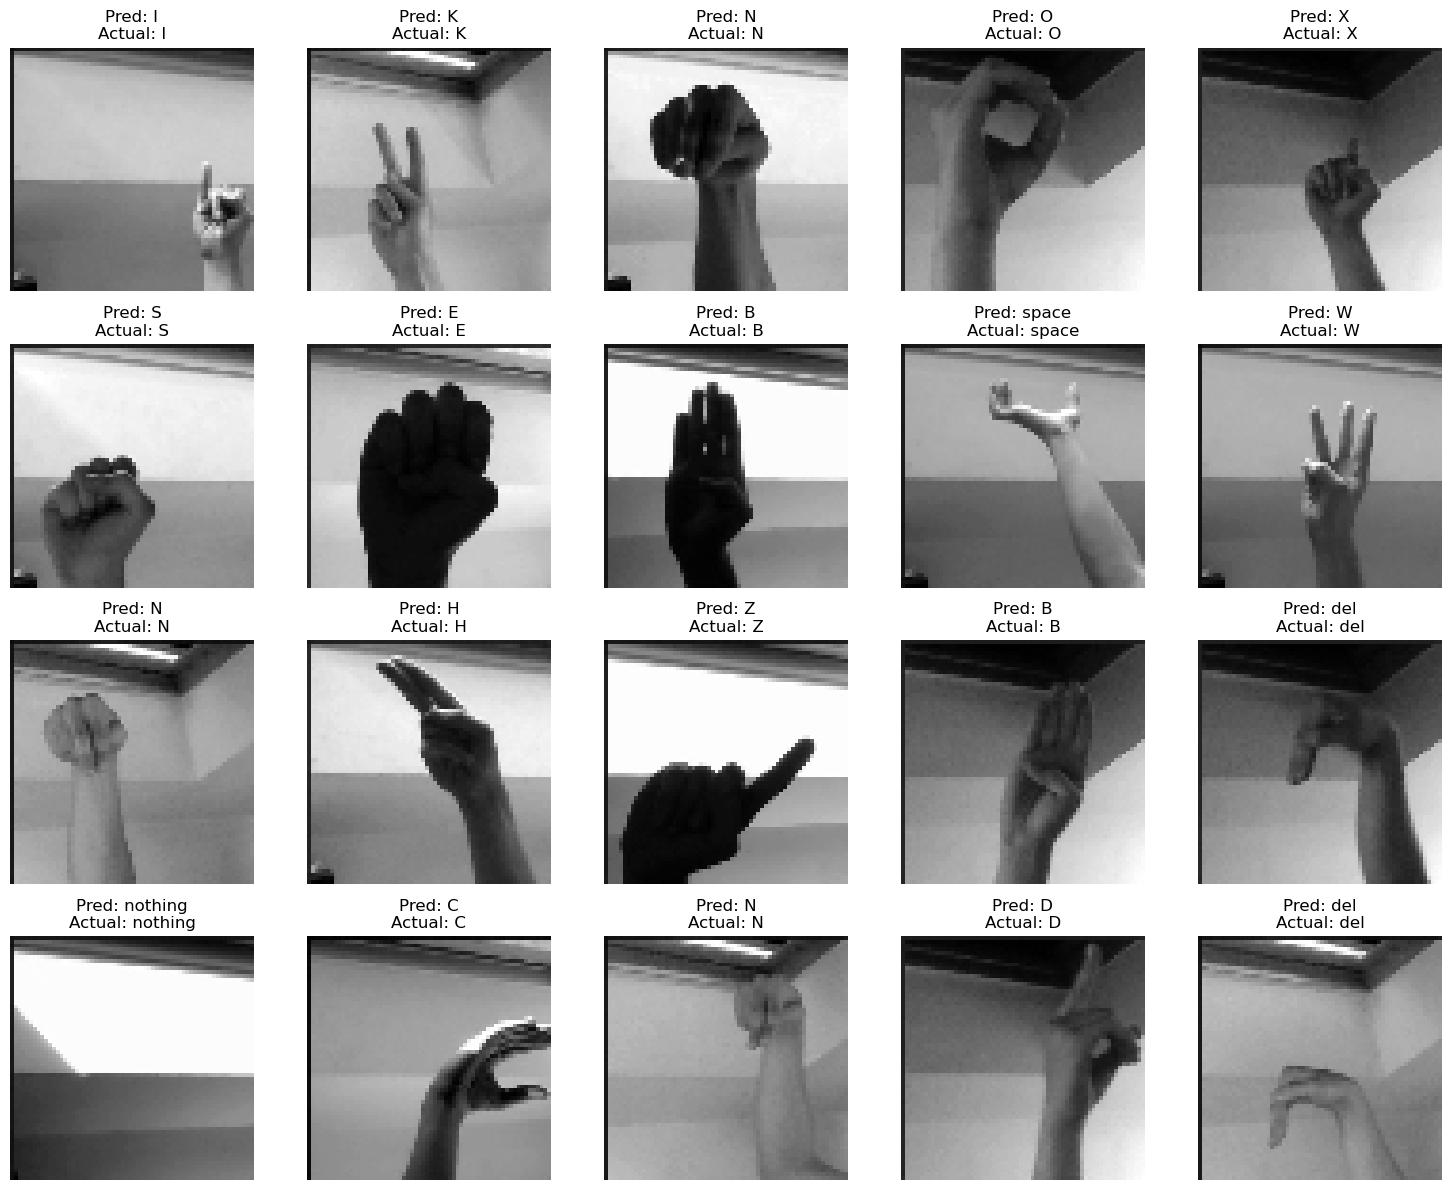

In [92]:
stampa_previsioni(val_images,val_labels,label_encoder.inverse_transform(y_val_pred))

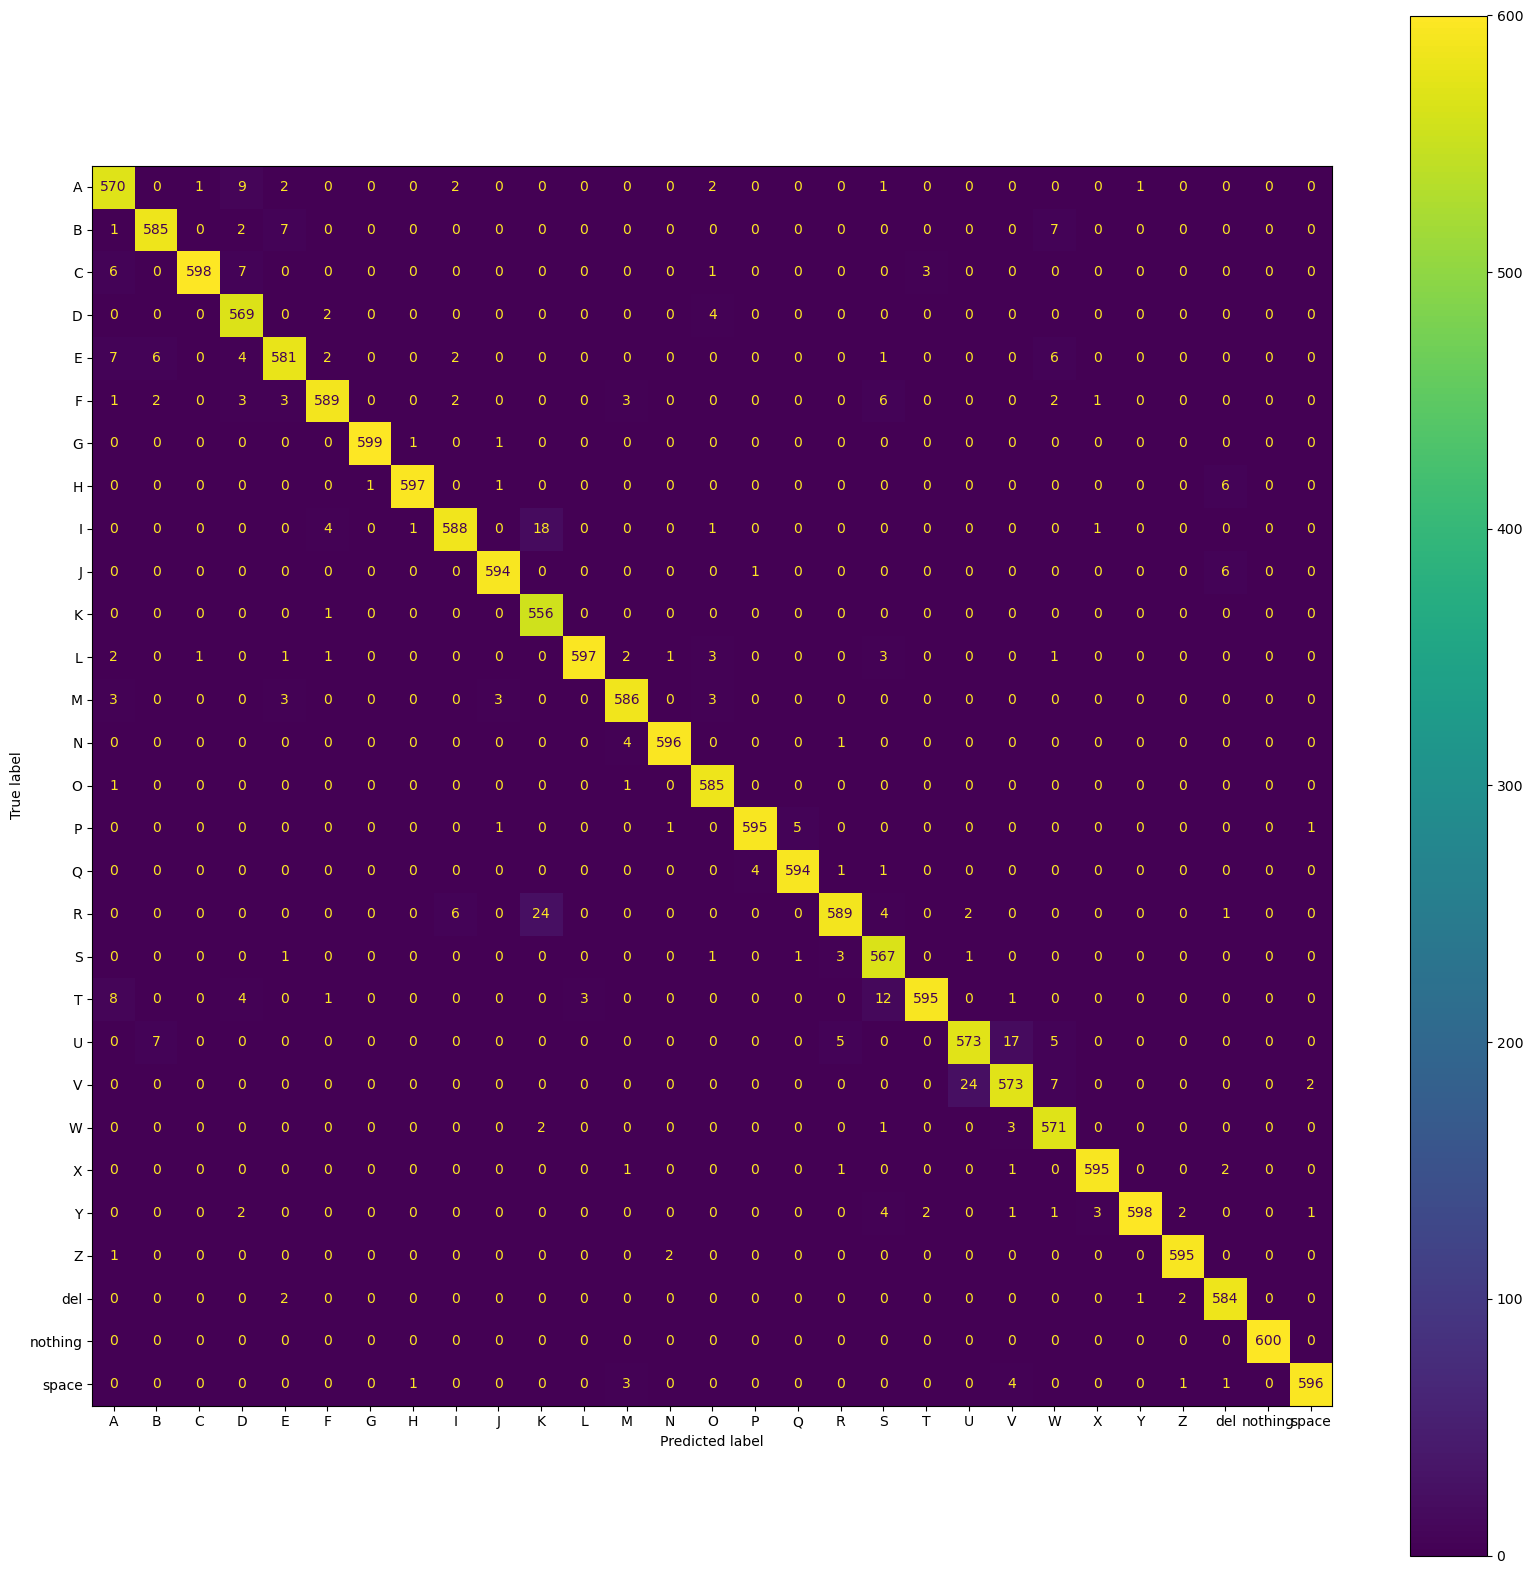

In [93]:
fig,ax=plt.subplots(figsize=(20, 20))
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_val_pred), val_labels)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=sorted(labels)).plot(ax=ax)
plt.show()

# Tentativo 2 PCA+Rete Neurale

In [94]:
pca = PCA(0.8)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [95]:
val_pca = pca.transform(val_images_vectorized)

In [97]:
train_pca.shape

(69600, 12)

In [98]:
model_3 = models.Sequential([
    layers.Dense(12, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [99]:
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [101]:
model_3.fit(train_pca, train_labels_encoded, epochs=100,validation_data=[val_pca,val_labels_encoded],callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 972us/step - loss: 2.2577 - accuracy: 0.3094 - val_loss: 1.7787 - val_accuracy: 0.4329
Epoch 2/100
2175/2175 [==============================] - 2s 885us/step - loss: 1.5739 - accuracy: 0.4926 - val_loss: 1.4290 - val_accuracy: 0.5350
Epoch 3/100
2175/2175 [==============================] - 2s 908us/step - loss: 1.3131 - accuracy: 0.5720 - val_loss: 1.2263 - val_accuracy: 0.6022
Epoch 4/100
2175/2175 [==============================] - 2s 901us/step - loss: 1.1537 - accuracy: 0.6236 - val_loss: 1.1135 - val_accuracy: 0.6294
Epoch 5/100
2175/2175 [==============================] - 2s 882us/step - loss: 1.0407 - accuracy: 0.6590 - val_loss: 1.0184 - val_accuracy: 0.6655
Epoch 6/100
2175/2175 [==============================] - 2s 876us/step - loss: 0.9557 - accuracy: 0.6861 - val_loss: 0.9612 - val_accuracy: 0.6843
Epoch 7/100
2175/2175 [==============================] - 2s 894us/step - loss: 0.8921 - accuracy: 0.7050 - val_loss: 0

In [102]:
y_val_pred = model_3.predict(val_pca)
y_val_pred = np.argmax(y_val_pred,axis=1)

544/544 [==============================] - 0s 512us/step


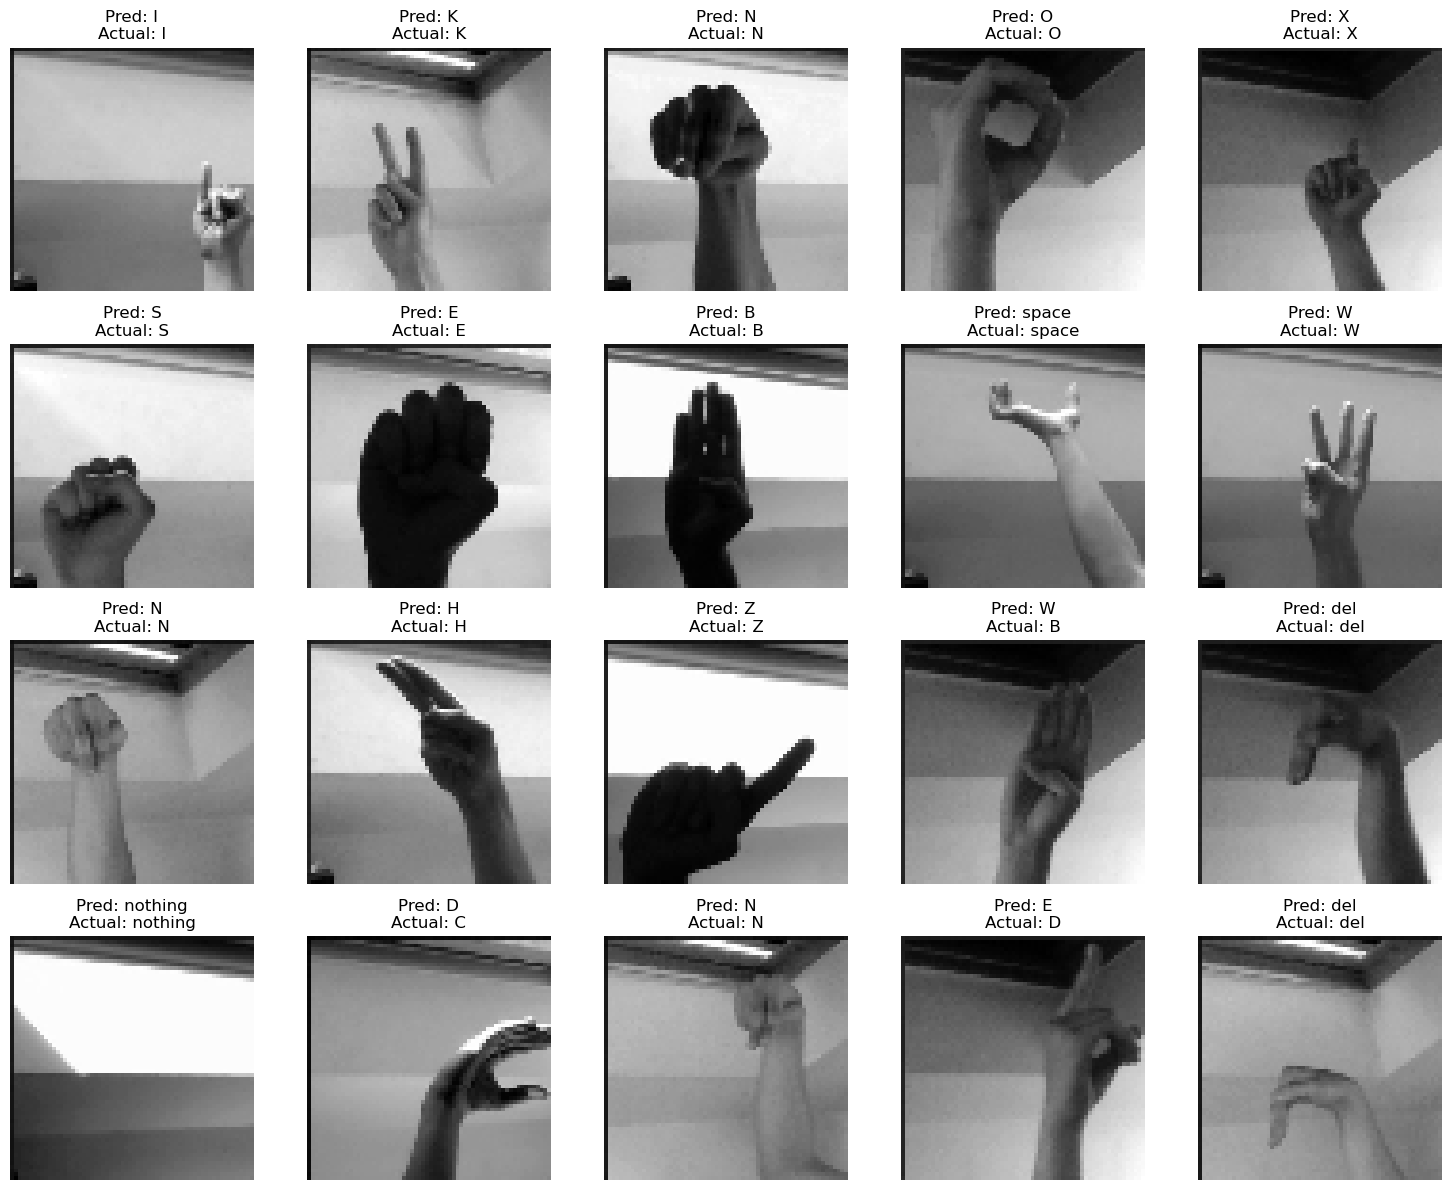

In [103]:
stampa_previsioni(val_images,val_labels,label_encoder.inverse_transform(y_val_pred))

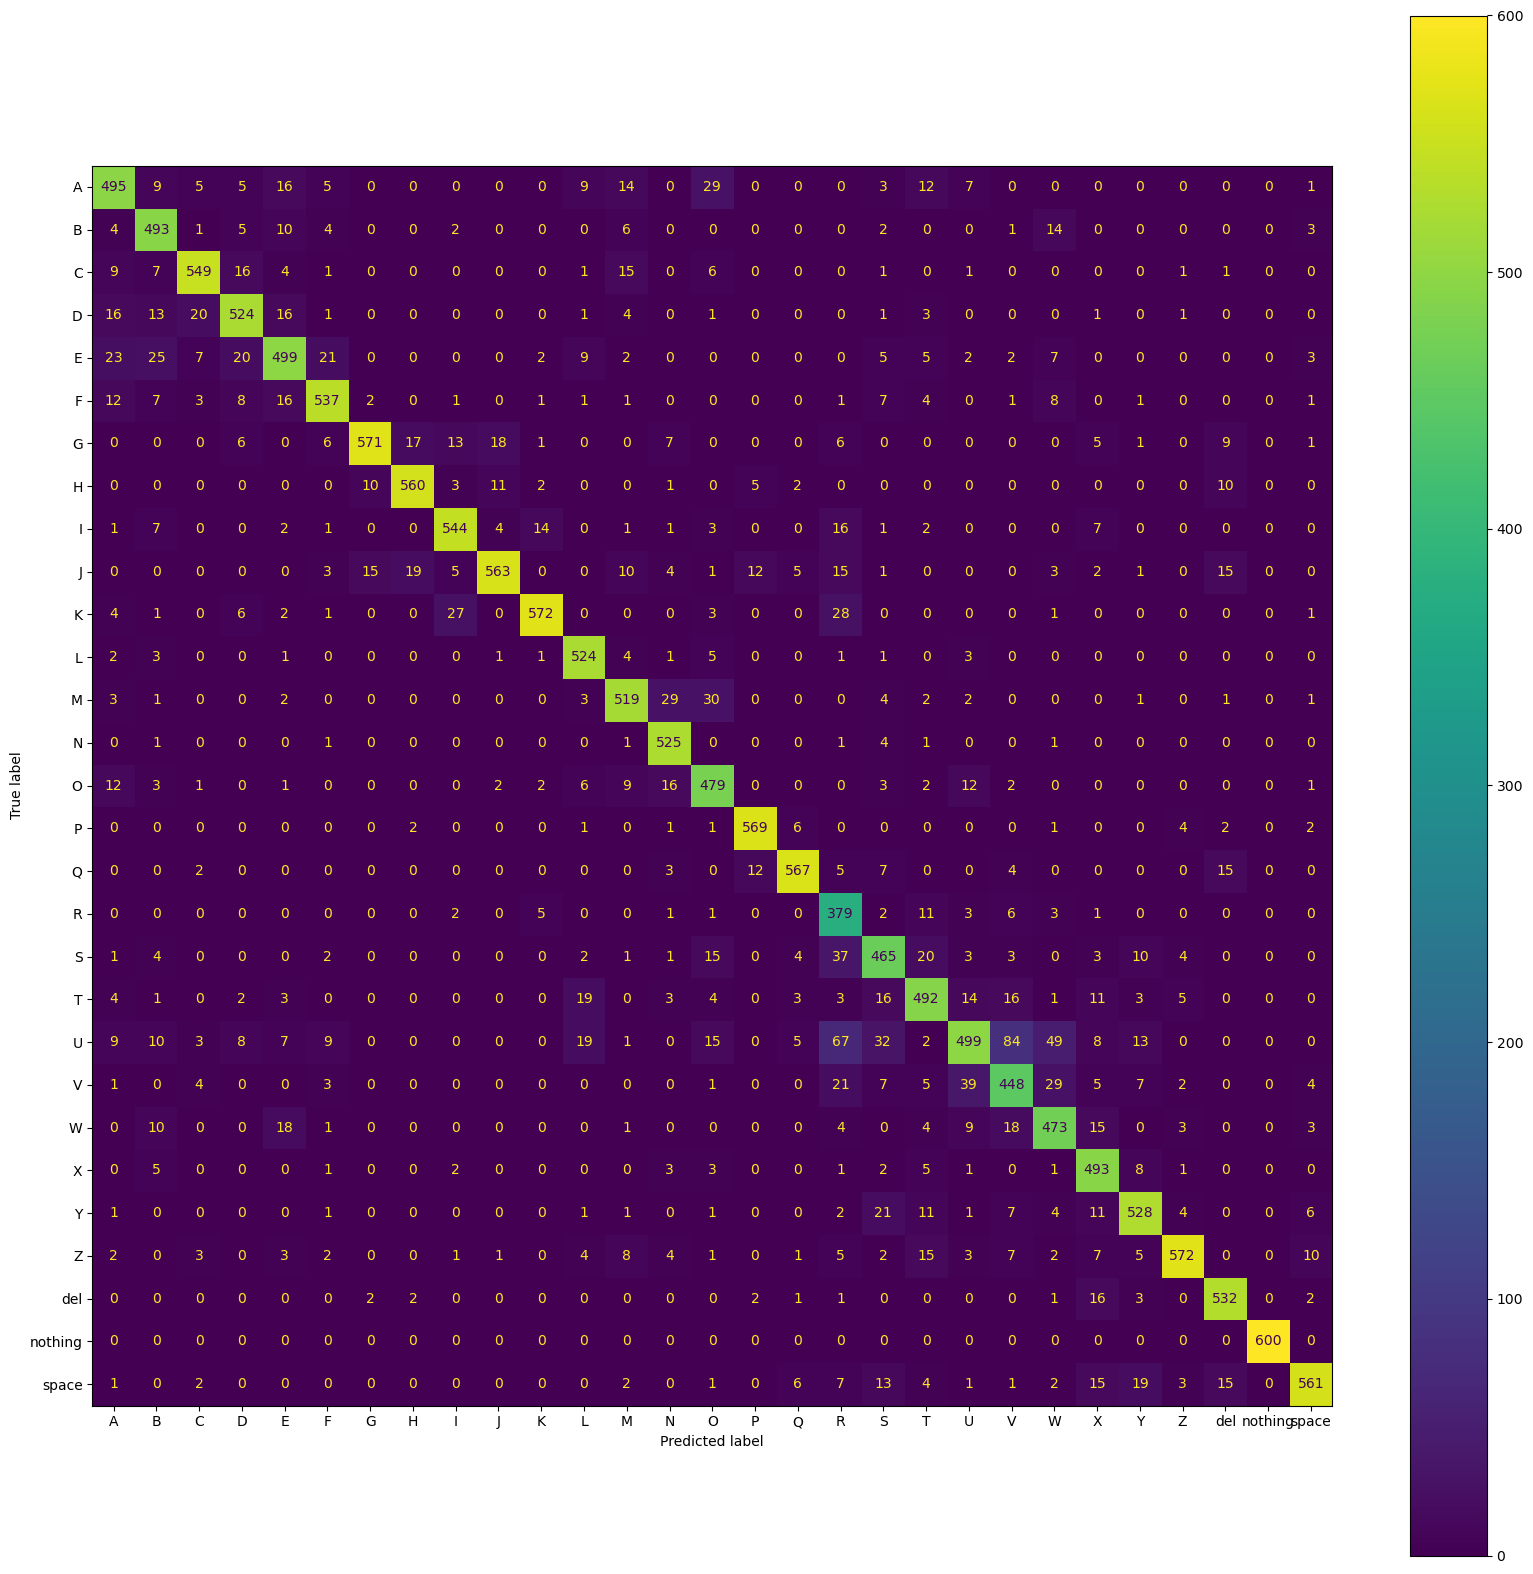

In [104]:
fig,ax=plt.subplots(figsize=(20, 20))
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_val_pred), val_labels)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=sorted(labels)).plot(ax=ax)
plt.show()

forse la varianza rappresentata non è abbastanza

# Tuning degli iperparametri su rete neurale + pca

In [95]:
pca = PCA(0.90)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [96]:
val_pca = pca.transform(val_images_vectorized)

In [180]:
model_3_pca = models.Sequential([
    layers.Dense(40, activation='tanh'),
    layers.Dense(256, activation='relu6'),
    layers.Dense(29, activation='softmax')
])

In [181]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [100]:
from bayes_opt import BayesianOptimization
def create_model(dense_units1,learning_rate):
    model = models.Sequential([
        layers.Dense(111, activation='tanh'),
        layers.Dense(int(dense_units1), activation='relu6'),
        layers.Dense(29, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(dense_units1, learning_rate):
    model = create_model(dense_units1,learning_rate)
    
    history = model.fit(train_pca, train_labels_encoded,
                        validation_data=(val_pca, val_labels_encoded),
                        epochs=10,
                        batch_size=32,verbose=0)
    
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Imposta i parametri di ricerca
pbounds = {
    'learning_rate':(0.0001,0.001),
    'dense_units1': (128, 512),
    
    
}
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Avvia l'ottimizzazione
optimizer.maximize(init_points=5, n_iter=10)

# Visualizza i migliori parametri trovati
print("Best hyperparameters: ", optimizer.max)

|   iter    |  target   | dense_... | learni... |
-------------------------------------------------
| 1         | 0.7912    | 271.8     | 0.0009556 |
| 2         | 0.7388    | 409.1     | 0.0006388 |
| 3         | 0.4054    | 187.9     | 0.0002404 |
| 4         | 0.7003    | 150.3     | 0.0008796 |
| 5         | 0.7661    | 358.8     | 0.0007373 |
| 6         | 0.4602    | 270.4     | 0.0002659 |
| 7         | 0.7995    | 271.9     | 0.0009935 |
| 8         | 0.7466    | 273.6     | 0.000761  |
| 9         | 0.7859    | 357.1     | 0.0008424 |
| 10        | 0.4278    | 355.3     | 0.0002092 |
| 11        | 0.6643    | 360.6     | 0.0005015 |
| 12        | 0.6979    | 407.4     | 0.0005044 |
| 13        | 0.572     | 410.8     | 0.0003348 |
| 14        | 0.6891    | 357.9     | 0.0005404 |
| 15        | 0.7152    | 274.9     | 0.0006968 |
Best hyperparameters:  {'target': 0.7995402216911316, 'params': {'dense_units1': 271.9272824639362, 'learning_rate': 0.0009935486153941585}}


In [102]:
model_1 = create_model(optimizer.max["params"]["dense_units1"],optimizer.max["params"]["learning_rate"])

In [103]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_pca, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.7025 - accuracy: 0.1957 - val_loss: 2.3179 - val_accuracy: 0.2817
Epoch 2/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.0572 - accuracy: 0.3579 - val_loss: 1.8320 - val_accuracy: 0.4222
Epoch 3/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.6657 - accuracy: 0.4754 - val_loss: 1.5155 - val_accuracy: 0.5236
Epoch 4/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.3876 - accuracy: 0.5591 - val_loss: 1.2832 - val_accuracy: 0.5930
Epoch 5/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.1842 - accuracy: 0.6231 - val_loss: 1.0986 - val_accuracy: 0.6529
Epoch 6/100
2175/2175 [==============================] - 2s 1ms/step - loss: 1.0363 - accuracy: 0.6686 - val_loss: 0.9720 - val_accuracy: 0.6965
Epoch 7/100
2175/2175 [==============================] - 3s 1ms/step - loss: 0.9181 - accuracy: 0.7088 - val_loss: 0.8723 - val_ac

In [4]:
%load_ext tensorboard 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/progettoMl2/logs/NN" --port=8008

In [105]:
model_1.save("./Modelli/PCA_NN")

INFO:tensorflow:Assets written to: ./Modelli/PCA_NN/assets


# CNN 

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [118]:
model = Sequential()

model = models.Sequential()
# 1st convolution layer
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.5))
# fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(29, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 21, 21, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 21, 21, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 16)        1040      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 16)       

In [119]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [120]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

prima_addestrato con adam e poi con sgd strano

In [33]:
train_images_norm.shape

(69600, 100, 100, 3)

In [121]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback],shuffle=True)

Epoch 1/100
2175/2175 [==============================] - 45s 21ms/step - loss: 2.1304 - accuracy: 0.3481 - val_loss: 1.1583 - val_accuracy: 0.6836
Epoch 2/100
2175/2175 [==============================] - 42s 19ms/step - loss: 1.2010 - accuracy: 0.6003 - val_loss: 0.7621 - val_accuracy: 0.7909
Epoch 3/100
2175/2175 [==============================] - 39s 18ms/step - loss: 0.9410 - accuracy: 0.6817 - val_loss: 0.6646 - val_accuracy: 0.8015
Epoch 4/100
2175/2175 [==============================] - 41s 19ms/step - loss: 0.8066 - accuracy: 0.7250 - val_loss: 0.7391 - val_accuracy: 0.7502
Epoch 5/100
2175/2175 [==============================] - 41s 19ms/step - loss: 0.7199 - accuracy: 0.7553 - val_loss: 0.5321 - val_accuracy: 0.8467
Epoch 6/100
2175/2175 [==============================] - 41s 19ms/step - loss: 0.6590 - accuracy: 0.7740 - val_loss: 0.4903 - val_accuracy: 0.8645
Epoch 7/100
2175/2175 [==============================] - 41s 19ms/step - loss: 0.6064 - accuracy: 0.7920 - val_loss: 0

In [122]:
model.save("./Modelli/cnn")

INFO:tensorflow:Assets written to: ./Modelli/cnn/assets


INFO:tensorflow:Assets written to: ./Modelli/cnn/assets


In [130]:
model = models.load_model("./Modelli/cnn")

# CNN 2

# Tuning degli iperparametri su rete cnn

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [8]:
from bayes_opt import BayesianOptimization
def create_model(dense_units,filter_1,filter_2,filter_size_1,filter_size_2,pool_size_1,pool_size_2,dropout,learning_rate):
    model = models.Sequential([
        Conv2D(int(filter_1), kernel_size=(int(filter_size_1), int(filter_size_1)), activation='relu', padding='same', input_shape=(64,64,1)),
        MaxPooling2D(pool_size=(int(pool_size_1), int(pool_size_1))),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(int(filter_2), kernel_size=(int(filter_size_2), int(filter_size_2)), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(int(pool_size_2), int(pool_size_2))),
        Dropout(dropout),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(29, activation='softmax')
       
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(dense_units,filter_1,filter_2,filter_size_1,filter_size_2,pool_size_1,pool_size_2,dropout,learning_rate):
    model = create_model(dense_units,filter_1,filter_2,filter_size_1,filter_size_2,pool_size_1,pool_size_2,dropout,learning_rate)
    
    history = model.fit(train_images_norm, train_labels_encoded,
                        validation_data=(val_images_norm, val_labels_encoded),
                        epochs=5,
                        batch_size=32,verbose=0)
    
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Imposta i parametri di ricerca
pbounds = {
    'learning_rate':(0.0001,0.001),
    'dense_units': (128, 256),
    "filter_1":(8,32),
    "filter_2":(8,32),
    "filter_size_1":(2,10),
    "filter_size_2":(2,10),
    "pool_size_1":(2,7),
    "pool_size_2":(2,7),
    "dropout":(0,0.7)
    

    
    
}
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

In [ ]:
# Avvia l'ottimizzazione
optimizer.maximize(init_points=5, n_iter=10)
# Visualizza i migliori parametri trovati
print("Best hyperparameters: ", optimizer.max)

In [20]:

optimizer={'target': 0.9725862145423889, 'params': {'dense_units': 221.62968250280088, 'dropout': 0.015020223708510347, 'filter_1': 32.0, 'filter_2': 30.192731545495196, 'filter_size_1': 8.809905385918354, 'filter_size_2': 9.785196867887354, 'learning_rate': 0.0001, 'pool_size_1': 4.909869163430479, 'pool_size_2': 7.0}}
best_params = optimizer["params"]
#optimizer.max["params"]

In [12]:
model_1 = create_model(best_params["dense_units"],best_params["filter_1"],best_params["filter_2"],best_params["filter_size_1"],best_params["filter_size_2"],best_params["pool_size_1"],best_params["pool_size_2"],best_params["dropout"],best_params["learning_rate"])

2024-06-16 10:18:04.321233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model_1.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 182s 83ms/step - loss: 1.5542 - accuracy: 0.5615 - val_loss: 0.7612 - val_accuracy: 0.7794
Epoch 2/100
2175/2175 [==============================] - 178s 82ms/step - loss: 0.5599 - accuracy: 0.8368 - val_loss: 0.3470 - val_accuracy: 0.9109
Epoch 3/100
2175/2175 [==============================] - 182s 84ms/step - loss: 0.3205 - accuracy: 0.9081 - val_loss: 0.3199 - val_accuracy: 0.8997
Epoch 4/100
2175/2175 [==============================] - 178s 82ms/step - loss: 0.2145 - accuracy: 0.9392 - val_loss: 0.1632 - val_accuracy: 0.9549
Epoch 5/100
2175/2175 [==============================] - 179s 82ms/step - loss: 0.1550 - accuracy: 0.9570 - val_loss: 0.2422 - val_accuracy: 0.9166
Epoch 6/100
2175/2175 [==============================] - 179s 82ms/step - loss: 0.1180 - accuracy: 0.9675 - val_loss: 0.0746 - val_accuracy: 0.9834
Epoch 7/100
2175/2175 [==============================] - 177s 81ms/step - loss: 0.0936 - accuracy: 0.9751 - val_

In [22]:
model_1.save("./Modelli/tuned_cnn")

INFO:tensorflow:Assets written to: ./Modelli/tuned_cnn/assets


INFO:tensorflow:Assets written to: ./Modelli/tuned_cnn/assets


# Landmarks

estrazione dei landmarks dalle immagini

In [4]:
import cv2
import mediapipe as mp
import numpy as np

# Inizializza Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def process_images_with_mediapipe(images,labels):
    landmarks_list = []
    skipped_index = []
    i = 0
    for img in tqdm(images, desc="Elaborazione delle immagini"):
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)
                
        if result.multi_hand_landmarks:
            hand_landmarks = result.multi_hand_landmarks[0]  # Estrai solo i landmarks della mano dominante
            # Estrai le coordinate x e y dei punti di riferimento delle mani
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)

        else:
            if(labels[i]!="nothing"):
               skipped_index.append(i)
            landmarks =  np.zeros(42)
        landmarks_list.append(landmarks)
        i+=1
    print("Skipped:",len(skipped_index))
    return landmarks_list,skipped_index


train_images_landmarks,skipped_index = process_images_with_mediapipe(train_images,train_labels)

hands.close()


Elaborazione delle immagini: 100%|██████████| 87000/87000 [30:44<00:00, 47.17it/s]   

Skipped: 20327


In [16]:
np.save("landmarks/landmarks",train_images_landmarks)

In [5]:
landmarks_np= np.array(train_images_landmarks)

In [7]:
landmarks_np_cleaned = np.delete(landmarks_np,skipped_index,axis=0)
labels_cleaned = np.delete(train_labels,skipped_index)

In [13]:
np.save("landmarks/train_images_landmarks.npy", landmarks_np_cleaned)
np.save("landmarks/train_images_labels.npy", labels_cleaned)

In [30]:
landmarks_np_cleaned=np.load("landmarks/train_images_landmarks.npy")

In [12]:
labels_cleaned = np.load("landmarks/train_images_labels.npy")

In [13]:
x_train,x_val,y_train,y_val = train_test_split(landmarks_np_cleaned,labels_cleaned,random_state=42)

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [15]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

creazione dei modelli basati su landmarks

In [16]:
model_landmarks = models.Sequential([
    layers.Dense(42, activation='relu'),
    layers.Dense(256, activation='relu'),
     layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

2024-06-16 20:16:29.474506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [18]:
model_landmarks.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model_landmarks.fit(x_train, y_train_encoded, epochs=100, batch_size=32,validation_data=(x_val, y_val_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.6197 - accuracy: 0.8356 - val_loss: 0.2145 - val_accuracy: 0.9513
Epoch 2/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1857 - accuracy: 0.9541 - val_loss: 0.2057 - val_accuracy: 0.9465
Epoch 3/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1406 - accuracy: 0.9628 - val_loss: 0.1269 - val_accuracy: 0.9703
Epoch 4/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1158 - accuracy: 0.9681 - val_loss: 0.1164 - val_accuracy: 0.9690
Epoch 5/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1034 - accuracy: 0.9702 - val_loss: 0.2209 - val_accuracy: 0.9310
Epoch 6/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0872 - accuracy: 0.9745 - val_loss: 0.1069 - val_accuracy: 0.9710
Epoch 7/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0820 - accuracy: 0.9765 - val_loss: 0.0742 - val_ac

In [20]:
model_landmarks.save("./Modelli/nn_landmarks.h5")

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

# Addestra il modello
clf.fit(x_train, y_train)

# Predice i valori di test
y_pred = clf.predict(x_train)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [33]:
y_pred = clf.predict(x_val)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [37]:
with open('./Modelli/tree_landmarks.pkl', 'wb') as file:
    pickle.dump(clf, file)